In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np
import json

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pydot

In [2]:
print(tf.__version__)

2.7.0


In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [5]:
def create_df(path):
    with open(path) as file: 
        data = json.load(file)
    speaker = []
    utterance = []
    emotion = []
    annotation = []
    for d in data: 
        speaker.extend([d[i]['speaker'] for i in range(len(d))])
        utterance.extend([d[i]['utterance'] for i in range(len(d))])
        emotion.extend([d[i]['emotion'] for i in range(len(d))])
        annotation.extend([d[i]['annotation'] for i in range(len(d))])

    df = pd.DataFrame({'speaker':speaker,'utterance':utterance,
                    'emotion':emotion, 'annotation':annotation})
    
    df = clean_utterance(df)
    
    return df

In [6]:
def clean_utterance(df):
    utterance = df['utterance']
    new_utterance = []
    for ut in utterance: 
        token = ut.split()
        clean_token = list(map(lambda x: x.replace("\x92","'"), token))
        clean_sent = " ".join(clean_token)
        new_utterance.append(clean_sent)
    df['utterance'] = new_utterance

    return df

In [7]:
train_df = create_df('friends_train.json')
test_df = create_df('friends_test.json')
dev_df = create_df('friends_dev.json')

In [8]:
train_df.dropna(axis = 0, how ='any',inplace=True) 
train_df['Num_words_text'] = train_df['utterance'].apply(lambda x:len(str(x).split())) 
mask = train_df['Num_words_text'] >2
train_df = train_df[mask]

print('-------Train data--------')
print(train_df['emotion'].value_counts())
print(len(train_df))
print('-------------------------')
max_train_sentence_length  = train_df['Num_words_text'].max()

train_df['utterance'] = train_df['utterance'].apply(clean_text)

print('Train Max Sentence Length :'+str(max_train_sentence_length))

-------Train data--------
neutral        3637
non-neutral    1729
joy             972
surprise        837
anger           423
sadness         319
disgust         209
fear            160
Name: emotion, dtype: int64
8286
-------------------------
Train Max Sentence Length :69


In [9]:
test_df.dropna(axis = 0, how ='any',inplace=True) 
test_df['Num_words_text'] = test_df['utterance'].apply(lambda x:len(str(x).split())) 
mask = test_df['Num_words_text'] >2
test_df = test_df[mask]

print('-------Train data--------')
print(test_df['emotion'].value_counts())
print(len(test_df))
print('-------------------------')
max_test_sentence_length  = test_df['Num_words_text'].max()

test_df['utterance'] = test_df['utterance'].apply(clean_text)

print('Test Max Sentence Length :'+str(max_test_sentence_length))

-------Train data--------
neutral        993
non-neutral    470
joy            221
surprise       193
anger          134
sadness         78
disgust         61
fear            29
Name: emotion, dtype: int64
2179
-------------------------
Test Max Sentence Length :45


---

### CNN Model 

In [30]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_df['utterance'].tolist())


print(str(tokenizer.texts_to_sequences(['hope me are you'])))

[[472, 1, 18, 2]]


In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['utterance'].tolist(),\
                                                      train_df['emotion'].tolist(),\
                                                      test_size=0.01,\
                                                      stratify = train_df['emotion'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_df['utterance'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_df['emotion'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:8203
Class distributionCounter({'neutral': 3600, 'non-neutral': 1712, 'joy': 962, 'surprise': 829, 'anger': 419, 'sadness': 316, 'disgust': 207, 'fear': 158})
Valid data len:83
Class distributionCounter({'neutral': 37, 'non-neutral': 17, 'joy': 10, 'surprise': 8, 'anger': 4, 'sadness': 3, 'disgust': 2, 'fear': 2})
[ 14  78  20 147   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


C:\Users\rpeng\AppData\Local\Temp/ipykernel_22352/1932801625.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
C:\Users\rpeng\AppData\Local\Temp/ipykernel_22352/1932801625.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
C:\Users\rpeng\AppData\Local\Temp/ipykernel_22352/1932801625.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

In [32]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['neutral', 'joy', 'non-neutral', 'anger', 'non-neutral', 'joy', 'disgust', 'non-neutral', 'surprise', 'non-neutral']
Text to number
[4 3 5 0 5 3 1 5 7 5]
Number to category
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [34]:
max_features =20000
embedding_dim = 64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.001)))                                    

model.add(tf.keras.layers.Conv1D(64,8, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.001),\
                                 bias_regularizer = regularizers.l2(0.001)))       

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(8, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 33, 64)            32832     
                                                                 
 batch_normalization (BatchN  (None, 33, 64)           256       
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 5

In [36]:
epochs = 100
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


c:\users\rpeng\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


65/65 [==============================] - 7s 35ms/step - loss: 2.2289 - categorical_accuracy: 0.3704 - val_loss: 2.0465 - val_categorical_accuracy: 0.4458
Epoch 2/100
65/65 [==============================] - 2s 29ms/step - loss: 1.7371 - categorical_accuracy: 0.4642 - val_loss: 2.0670 - val_categorical_accuracy: 0.4458
Epoch 3/100
65/65 [==============================] - 2s 25ms/step - loss: 1.5952 - categorical_accuracy: 0.5019 - val_loss: 2.0606 - val_categorical_accuracy: 0.4458
Epoch 4/100
65/65 [==============================] - 1s 19ms/step - loss: 1.4550 - categorical_accuracy: 0.5592 - val_loss: 2.0575 - val_categorical_accuracy: 0.4578
Epoch 5/100
65/65 [==============================] - 1s 20ms/step - loss: 1.3256 - categorical_accuracy: 0.6075 - val_loss: 2.0339 - val_categorical_accuracy: 0.4699
Epoch 6/100
65/65 [==============================] - 1s 22ms/step - loss: 1.2051 - categorical_accuracy: 0.6635 - val_loss: 2.0081 - val_categorical_accuracy: 0.4819
Epoch 7/100
65/6

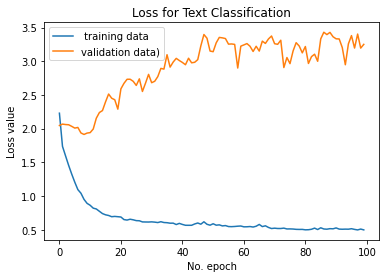

In [37]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

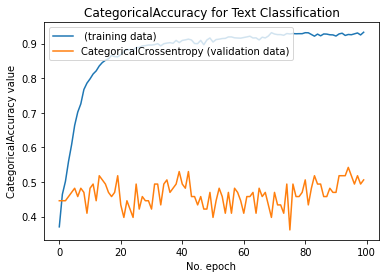

In [38]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


##### The first model we did, it through CNN. However, it's very clear from the training_accuracy VS validation_accuracy graph that
##### this CNN modeld is overfitting. We have tried to used dropout functions and increasing the regulization, and the result stays 
#### the same. After the failiar of tuning the model,we decide to move on to another model, which is Transformer with BERT.

---

### Transformer with BERT

In [10]:
from transformers import BertTokenizer

In [11]:
# set array dimensions
seq_len = 512
num_samples = len(train_df)

# initialize empty zero arrays
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# check shape
Xids.shape

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, phrase in enumerate(train_df['utterance']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # assign tokenized outputs to respective rows in numpy arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [12]:
le = LabelEncoder()

labels = le.fit_transform(train_df['emotion'])
labels = np.asarray( tf.keras.utils.to_categorical(labels))
list(le.classes_)

['anger',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'non-neutral',
 'sadness',
 'surprise']

In [13]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (8,)), types: (tf.float64, tf.float64, tf.float32)>

In [15]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

In [16]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (8,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [17]:
batch_size = 8

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (8, 512), attention_mask: (8, 512)}, (8, 8)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [18]:
split = 0.9

size = int((Xids.shape[0] / batch_size) * split)

In [19]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

---

In [20]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [22]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(8, activation='softmax', name='outputs')(x)

In [23]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 512                                               
                                , 768),                                                       

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
932/932 [==============================] - 268s 282ms/step - loss: 1.5332 - accuracy: 0.4544 - val_loss: 1.3231 - val_accuracy: 0.5243
Epoch 2/10
932/932 [==============================] - 263s 282ms/step - loss: 1.3084 - accuracy: 0.5366 - val_loss: 1.0442 - val_accuracy: 0.6408
Epoch 3/10
932/932 [==============================] - 263s 282ms/step - loss: 1.1173 - accuracy: 0.6066 - val_loss: 0.8554 - val_accuracy: 0.7172
Epoch 4/10
932/932 [==============================] - 273s 293ms/step - loss: 0.8886 - accuracy: 0.6938 - val_loss: 0.5426 - val_accuracy: 0.8240
Epoch 5/10
932/932 [==============================] - 272s 292ms/step - loss: 0.6546 - accuracy: 0.7800 - val_loss: 0.3486 - val_accuracy: 0.8981
Epoch 6/10
932/932 [==============================] - 272s 291ms/step - loss: 0.4872 - accuracy: 0.8370 - val_loss: 0.2126 - val_accuracy: 0.9393
Epoch 7/10
932/932 [==============================] - 281s 302ms/step - loss: 0.3582 - accuracy: 0.8820 - val_loss: 0.2004 -

In [27]:
history.history


{'loss': [1.533194899559021,
  1.308354377746582,
  1.117310643196106,
  0.8886001706123352,
  0.6546065807342529,
  0.4871722459793091,
  0.358204185962677,
  0.28469955921173096,
  0.2293398082256317,
  0.18212135136127472],
 'accuracy': [0.45439913868904114,
  0.5366148352622986,
  0.6066255569458008,
  0.6938036680221558,
  0.7800429463386536,
  0.8370440006256104,
  0.8819742202758789,
  0.9065182209014893,
  0.9242221117019653,
  0.9416577219963074],
 'val_loss': [1.3231316804885864,
  1.0442216396331787,
  0.8553996682167053,
  0.5425655245780945,
  0.3485831916332245,
  0.21263262629508972,
  0.20043028891086578,
  0.1025436744093895,
  0.09450847655534744,
  0.048444122076034546],
 'val_accuracy': [0.5242718458175659,
  0.6407766938209534,
  0.7172330021858215,
  0.8240291476249695,
  0.8980582356452942,
  0.9393203854560852,
  0.9417475461959839,
  0.9733009934425354,
  0.9672330021858215,
  0.9866504669189453]}

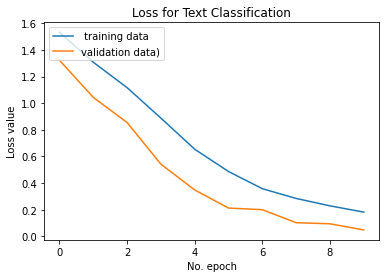

In [28]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

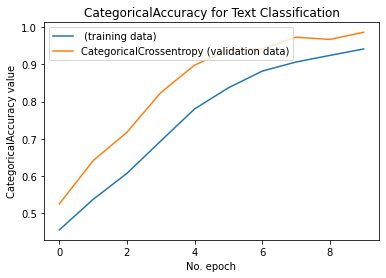

In [29]:
plt.plot(history.history['accuracy'], label=' (training data)')
plt.plot(history.history['val_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


#### The new model tested to be very sucessful. After only 10 epochs,we get over 90% accuracy on both training set and validation set. This model proved to be more effecteive on NLP models and text classification. 